# CC Scheme

In [5]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import os
import xcorr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%matplotlib notebook

In [7]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [8]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_lag = pd.to_timedelta((0,6),unit='h')
poi = {'name': 'MVC', 'latitude': -25.887, 'longitude': -177.188, 'elevation': 0., 'local_depth': 132.}

attrs = {
    'title': 'Monowai Volcanic Centre',
    'institution': 'Delft University of Technology, Department of Geoscience and Engineering',
    'author': 'Pieter Smets - P.S.M.Smets@tudelft.nl',
    'source': 'CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data',
}

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        # ('remove_sensitivity', {}),
        ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
}

In [9]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
    'IM.H03S1..EDH-IU.RAR.10.BHZ',
    'IM.H03S1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2015-01-15', '2015-01-18', freq='1D')

# inv = xcorr.util.get_pair_inventory(pairs, read_inventory('../data/Monowai_new.xml'), times)
inv = read_inventory('../data/Monowai_new.xml')

# fig = inv.plot(color=0., projection='local')

## Correlate one day of data

In [10]:
pp_sens = preprocess.copy()
pp_sens['EDH'] = [
    ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
    ('filter', {'type':'highpass','freq':.05}),
    ('detrend', { 'type': 'demean' }),
    ('remove_sensitivity', {}),
    ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
    ('decimate', { 'factor': 5 }),
    ('trim', {}),
    ('detrend', { 'type': 'demean' }),
    ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
]
pp_resp = preprocess.copy()
pp_resp['EDH'] = [
    ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
    ('filter', {'type':'highpass','freq':.05}),
    ('detrend', { 'type': 'demean' }),
    ('remove_response', {}),
    ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
    ('decimate', { 'factor': 5 }),
    ('trim', {}),
    ('detrend', { 'type': 'demean' }),
    ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
]

In [89]:
pair = pairs[0]
time = times[0]

ds_resp = xcorr.init(
    pair=pair,
    starttime=time,
    endtime=time + pd.offsets.DateOffset(1), 
    attrs=attrs,
    preprocess=pp_resp, 
    sampling_rate=sampling_rate, 
    window_length=window_length, 
    window_overlap=window_overlap, 
    clip_lag=clip_lag,
    unbiased_cc=False,
    inventory=inv,
    stationary_poi=poi,
)

ds_sens = xcorr.init(
    pair=pair,
    starttime=time,
    endtime=time + pd.offsets.DateOffset(1), 
    attrs=attrs,
    preprocess=pp_sens, 
    sampling_rate=sampling_rate, 
    window_length=window_length, 
    window_overlap=window_overlap, 
    clip_lag=clip_lag,
    unbiased_cc=False,
    inventory=inv,
    stationary_poi=poi,
)

In [90]:
xcorr.process(ds_resp, inventory=inv, client=client, test_run=True)
xcorr.process(ds_sens, inventory=inv, client=client, test_run=True)

IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T00:00:00: Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T00:00:00: Waveforms. CC. Done.


<IPython.core.display.Javascript object>


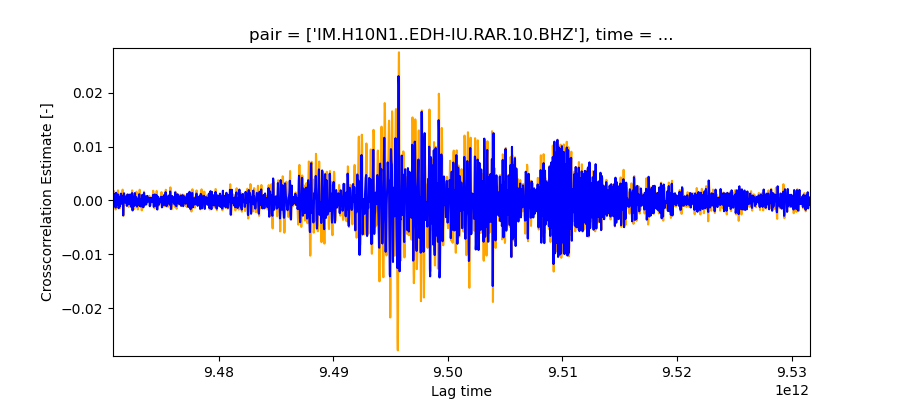

In [93]:
plt.figure(figsize=[9,4])
ds_resp.cc.loc[{'time': ds_resp.time[0]}].plot.line(x='lag',add_legend=False,color='orange')
ds_sens.cc.loc[{'time': ds_sens.time[0]}].plot.line(x='lag',add_legend=False,color='blue')

In [101]:
ds_resp.cc.assign_attrs({'pad': 1})

<xarray.DataArray 'cc' (pair: 1, time: 8, lag: 1080000)>
array([[[ 0.00103399,  0.00019238,  0.00018202, ...,  0.00022515,
          0.00035657,  0.00081134],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
  * pair     (pair) object 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * time     (time) datetime64[ns] 2015-01-15 ... 2015-01-15T21:00:00
  * lag      (lag) timedelta64[ns] 00:00:00 00:00:00.020000 ... 05:59:59.980000
Attributes:
    long_name:      Crosscorrelation Estimate
    standard_name:  crosscorrelation_estimate
    units:          -
    add_offset:     0.0
    scale_factor:   1.0
    valid_range:    [-1.  1.]
    normalize:      1
    bias_correct:   0
    unbiased:       0
    pad:            1

In [110]:
test = xr.DataArray()

In [109]:
ds_resp.cc.attrs['pad']

1

In [ ]:
xcorr.write(ds, 'test.nc', verb=1)

In [ ]:
ds1 = xcorr.read('test.nc', verb=1)

### A whole period

In [ ]:
def filename(pair:str,time:pd.datetime):
    return '{pair}.{y:04d}.{d:03d}.nc'.format(pair=pair,y=time.year,d=time.dayofyear)
dest = '/Users/psmets/Documents/Research/_studies/_hydro/monowai_remote/tests/full'

In [ ]:
warnings.filterwarnings('ignore') # no warnings of duplicate inventory items

for pair in pairs:
    print('---------------------------')
    print(pair)
    print('---------------------------')
    for time in times:
        ncfile = os.path.join(dest,pair,filename(pair, time))
        ds = False
        if os.path.isfile(ncfile):
            ds = xr.open_dataset(ncfile)
            if ds and np.all(ds.status.values == 1):
                ds.close()
                continue
        if not ds:
            ds = xcorr.init_dataset(
                pair=pair,
                starttime=time,
                endtime=time + pd.offsets.DateOffset(1), 
                attrs=attrs,
                preprocess=preprocess, 
                sampling_rate=sampling_rate, 
                window_length=window_length, 
                window_overlap=window_overlap, 
                clip_lag=clip_lag,
                unbiased_cc=False,
                inventory=inv,
                stationary_poi=poi,
            )
        try:
            xcorr.cc_dataset(
                ds,
                inventory=inv.select(
                    starttime=UTCDateTime(time),
                    endtime=UTCDateTime(time + pd.offsets.DateOffset(1))
                ),
                client=client,
                retry_missing=True,
            )
        except (KeyboardInterrupt, SystemExit):
            raise
        except Exception as e:
            print('An error occurred. Save and continue next timestep or pair.')
            print('Error:')
            print(e)
        if ds and np.any(ds.status.values != 0):
            xcorr.write_dataset(ds,ncfile)